In [11]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
# import polytope as pt
import matplotlib.pyplot as plt
import logging
# from pyomo.util.infeasible import log_infeasible_constraints
# Set the logger to DEBUG level
# logging.basicConfig(level=logging.DEBUG)

# GLOBAL VARIABLES
r_cm = 3   # cm 
L_cm = 5  # cm
Ts = 0.2   # s
MAX_deltaU = 1

def solve_cftoc_batch(q0, qf, N, r, L, Ts, MAX_deltaU):
    model = pyo.ConcreteModel()

    #Define the variables
    nq = 5
    nu = 2
    model.N = N
    model.tidx = pyo.Set(initialize=range(N+1), ordered=True)
    model.tuidx = pyo.Set(initialize=range(N), ordered=True)
    model.qidx = pyo.Set(initialize=range(nq), ordered=True)
    model.uidx = pyo.Set(initialize=range(nu), ordered=True)

    model.q = pyo.Var(model.qidx, model.tidx)
    model.u = pyo.Var(model.uidx, model.tuidx, bounds=(-MAX_deltaU, MAX_deltaU))

    #Define the constraints
    #initial condition - fix these at the initial state
    model.init_condition = pyo.Constraint(model.qidx, rule=lambda model, i: model.q[i,0] == q0[i])

    #System dynamics, don't include the last time step, so use tuidx
    model.sys_dyn0 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[0, t+1] == model.q[0, t] + Ts*(r/2)*pyo.cos(model.q[2,t]) * (model.u[0, t] + model.u[1, t]))
    model.sys_dyn1 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[1, t+1] == model.q[1, t] + Ts*(r/2)*pyo.sin(model.q[2,t]) * (model.u[0, t] + model.u[1, t]))
    model.sys_dyn2 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[2, t+1] == model.q[2, t] + Ts*(r/L)*(-model.u[0, t] + model.u[1, t]))
    model.sys_dyn3 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[3, t+1] == model.q[3, t] + Ts*model.u[0, t])
    model.sys_dyn4 = pyo.Constraint(model.tuidx, rule=lambda model, t: model.q[4, t+1] == model.q[4, t] + Ts*model.u[1, t])
    
    #Final Constraint
    epsilon = 0.01
    model.final_constraint0 = pyo.Constraint(expr = (model.q[0,N] - qf[0])**2 <= epsilon)
    model.final_constraint1 = pyo.Constraint(expr = (model.q[1,N] - qf[1])**2 <= epsilon)
    # model.final_constraint2 = pyo.Constraint(expr = (model.q[2,N] - qf[2])**2 <= epsilon)
    # model.final_constraint3 = pyo.Constraint(expr = (model.q[3,N] - qf[3])**2 <= epsilon)
    # model.final_constraint4 = pyo.Constraint(expr = (model.q[4,N] - qf[4])**2 <= epsilon)


    # Cost function
    def cost_rule(model):
        cost_q = 0
        cost_u = 0

        # Make the difference in wheel angle, heading for the last 5% of the time steps as small as possible
        for t in range(int(0.95*model.N), model.N):
            cost_q += (model.q[2,t] - qf[2])**2 + (model.q[3,t] - qf[3])**2 + (model.q[4,t] - qf[4])**2

        # Minimize the control effort
        for t in model.tuidx:
            cost_u += model.u[0,t]**2 + model.u[1,t]**2

        return cost_q
    
    model.cost = pyo.Objective(rule=cost_rule, sense=pyo.minimize)

    # Solve the optimization problem
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
  
    feas = str(results.solver.termination_condition) == "optimal"
    qOpt = np.asarray([model.q[:,t]() for t in model.tidx]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tuidx]).T
    JOpt = model.cost()
    # log_infeasible_constraints(model)

    return feas, qOpt, uOpt, JOpt, model, results


q0 = np.array([0, 0, 0, 0, np.pi/2])
qf = np.array([0, 0, 0, 0, 0])
N = 10
feas, qOpt, uOpt, JOpt, model, results = solve_cftoc_batch(q0, qf, N, r_cm, L_cm, Ts, MAX_deltaU)


# Simulations/Animations

### Batch optimization for trajectory generation

In [12]:
q0 = [0,0, 0, np.pi, 0]
qf=[0,0,0,0,0]

N_batch = 100
[feas, q_traj_batch, u_traj_batch, JOpt, model, results] = solve_cftoc_batch(q0, qf, N_batch, r_cm, L_cm, Ts, MAX_deltaU)

#print out the final state
print(q_traj_batch[:,-1])
print(JOpt)
# print(feas)
# print(q_traj_batch)
# model.pprint()



[ 6.07350427e-13 -7.14744303e-13  1.38599676e+00  1.98659535e+00
  1.15499730e+00]
13.06271170732416


Plotting the Batch Trajectory

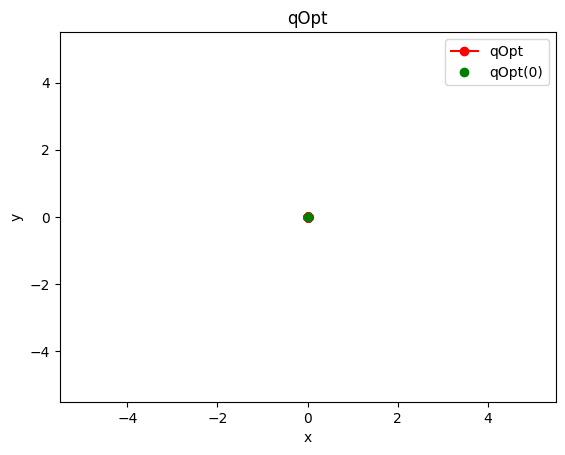

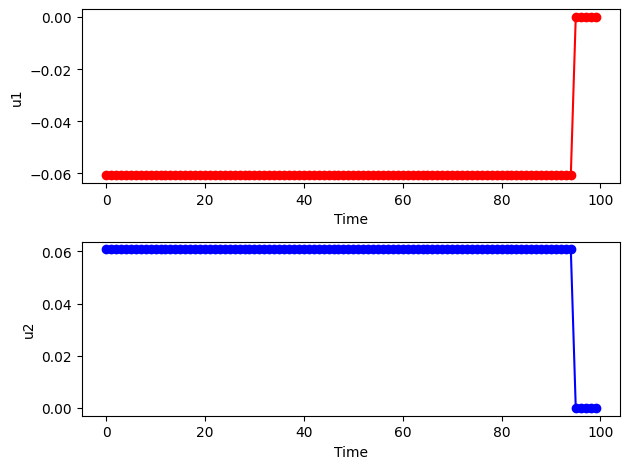

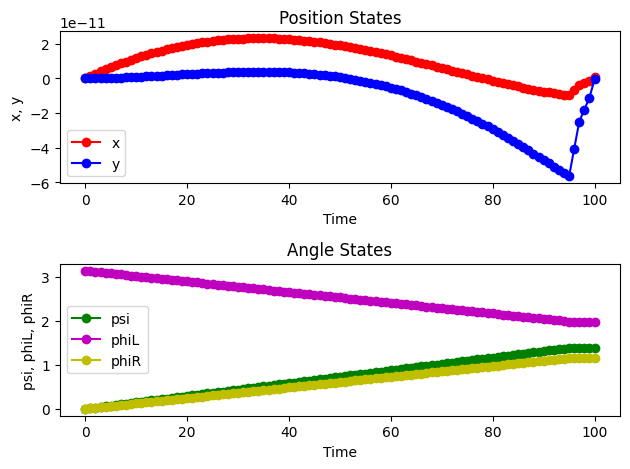

In [13]:
plt.figure()
plt.plot(q_traj_batch[0,:], q_traj_batch[1,:], 'ro-')
# Show the initial x,y position
plt.plot(q_traj_batch[0,0], q_traj_batch[1,0], 'go')
plt.xlim([min(q_traj_batch[0,:])-(r_cm+L_cm/2), max(q_traj_batch[0,:])+(r_cm+L_cm/2)])
plt.ylim([min(q_traj_batch[1,:])-(r_cm+L_cm/2), max(q_traj_batch[1,:])+(r_cm+L_cm/2)])

plt.xlabel('x')
plt.ylabel('y')
plt.title('qOpt')
plt.legend(['qOpt','qOpt(0)'])

# Plot inputs in two subplots
plt.figure()
plt.subplot(2,1,1)
plt.plot(range(N_batch), u_traj_batch[0,:], 'ro-')
plt.xlabel('Time')
plt.ylabel('u1')

plt.subplot(2,1,2)
plt.plot(range(N_batch), u_traj_batch[1,:], 'bo-')
plt.xlabel('Time')
plt.ylabel('u2')
plt.tight_layout()

# Plot all states
plt.figure()

# Subplot for x and y
plt.subplot(2, 1, 1)
plt.plot(range(N_batch+1), q_traj_batch[0,:], 'ro-', label='x')
plt.plot(range(N_batch+1), q_traj_batch[1,:], 'bo-', label='y')
plt.xlabel('Time')
plt.ylabel('x, y')
plt.legend()
plt.title('Position States')

# Subplot for psi, phiL, and phiR
plt.subplot(2, 1, 2)
plt.plot(range(N_batch+1), q_traj_batch[2,:], 'go-', label='psi')
plt.plot(range(N_batch+1), q_traj_batch[3,:], 'mo-', label='phiL')
plt.plot(range(N_batch+1), q_traj_batch[4,:], 'yo-', label='phiR')
plt.xlabel('Time')
plt.ylabel('psi, phiL, phiR')
plt.legend()
plt.title('Angle States')

plt.tight_layout()


### Animation

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle
import numpy as np

def plotRoverState(ax, x, y, psi, phiL, phiR, L, r_ratio):
    r = r_ratio * L / 2
    dx = (L / 2) * np.cos(psi + np.pi / 2)
    dy = (L / 2) * np.sin(psi + np.pi / 2)
    
    #Show the full trajectory
    ax.plot(q_traj_batch[0,:], q_traj_batch[1,:], 'k-', alpha=0.5)

    #Plot the rover
    ax.plot([x - dx, x + dx], [y - dy, y + dy], 'k-', linewidth=3)
    ax.plot(x, y, 'ko')
    ax.quiver(x, y, np.cos(psi), np.sin(psi), scale=20)
    
    wheelPosL = (x + dx, y + dy)
    wheelPosR = (x - dx, y - dy)

    circle1 = Circle(wheelPosL, r, edgecolor='b', facecolor='none')
    circle2 = Circle(wheelPosR, r, edgecolor='r', facecolor='none')
    ax.add_patch(circle1)
    ax.add_patch(circle2)

    ax.plot([wheelPosL[0], wheelPosL[0] + r * np.cos(phiL)], 
            [wheelPosL[1], wheelPosL[1] + r * np.sin(phiL)], 'b-')
    ax.plot([wheelPosR[0], wheelPosR[0] + r * np.cos(phiR)], 
            [wheelPosR[1], wheelPosR[1] + r * np.sin(phiR)], 'r-')

def calculate_wheel_positions(trajectory, L):
    N = len(trajectory)
    print(np.shape(trajectory))
    wheelL_pos = np.zeros((N, 2))
    wheelR_pos = np.zeros((N, 2))

    for i in range(N):
        x, y, psi, _, _ = trajectory[i]
        dx = (L / 2) * np.cos(psi + np.pi / 2)
        dy = (L / 2) * np.sin(psi + np.pi / 2)

        wheelL_pos[i] = [x + dx, y + dy]
        wheelR_pos[i] = [x - dx, y - dy]

    return wheelL_pos, wheelR_pos

def animate_trajectory(q_traj, u_traj, qf, L):
    n_k = np.shape(u_traj)[0]
    print(n_k)
    eps = 0.001
    for i in range(n_k):
        if ((q_traj[i,0] - qf[0])**2<= eps) & ((q_traj[i,1]-qf[1])**2<=eps) & ((q_traj[i,2]-qf[2])**2<=eps) & ((q_traj[i,3]-qf[3])**2<=eps) & ((q_traj[i,4]-qf[4])**2<=eps) & (u_traj[i,0]**2 <= eps) & (u_traj[i,1]**2<= eps):
            n_k = i
            break
    print(n_k)        
    wheelL_pos, wheelR_pos = calculate_wheel_positions(q_traj, L)

    fig = plt.figure(figsize=(14, 6))
    ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((2, 4), (0, 2))
    ax3 = plt.subplot2grid((2, 4), (0, 3))
    ax4 = plt.subplot2grid((2, 4), (1, 2))
    ax5 = plt.subplot2grid((2, 4), (1, 3))
    plt.tight_layout()

    def update(frame):
        ax1.clear()
        ax2.clear()
        ax3.clear()
        ax4.clear()
        ax5.clear()

        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_xlim([min(q_traj[:,0])-(r_cm+L_cm/2), max(q_traj[:,0])+(r_cm+L_cm/2)])
        ax1.set_ylim([min(q_traj[:,1])-(r_cm+L_cm/2), max(q_traj[:,1])+(r_cm+L_cm/2)])
        ax1.grid(True)
        ax1.set_aspect('equal')

        # Plot rover state
        plotRoverState(ax1, *q_traj[frame], L, 0.3)

        # Plot trajectory
        x, y, psi, phiL, phiR = q_traj.T
        ax2.plot(range(n_k), x[:n_k], '.-', label='X-pos')
        ax2.plot(range(n_k), y[:n_k], '.-', label='Y-pos')
        ax2.plot(range(n_k), psi[:n_k], '.-', label='Heading')
        ax2.axvline(frame, 0, 1)
        ax2.legend()

        # Plot wheel angles
        ax3.plot(range(n_k), phiL[:n_k], '.-b', label="Lwhl θ")
        ax3.plot(range(n_k), phiR[:n_k], '.-r', label="Rwhl θ")
        ax3.axvline(frame, 0, 1)
        ax3.legend()

        # Plot wheel positions
        ax4.plot(range(n_k), wheelL_pos[:n_k, 0], '.-b', label="Lwhl x")
        ax4.plot(range(n_k), wheelL_pos[:n_k, 1], '.-b', label="Lwhl y")
        ax4.plot(range(n_k), wheelR_pos[:n_k, 0], '.-r', label="Rwhl x")
        ax4.plot(range(n_k), wheelR_pos[:n_k, 1], '.-r', label="Rwhl y")
        ax4.axvline(frame, 0, 1)
        ax4.legend()

        # Plot inputs
        ax5.plot(range(n_k), u_traj[:n_k, 0], '.-b', label="uL")
        ax5.plot(range(n_k), u_traj[:n_k, 1], '.-r', label="uR")
        ax5.axvline(frame, 0, 1)
        ax5.legend()

        return ax1, ax2, ax3, ax4

    ani = FuncAnimation(fig, update, frames=n_k, repeat=False)
    return ani


ani = animate_trajectory(q_traj_batch.T, u_traj_batch.T, qf, L_cm)
# Display animation in Jupyter
from IPython.display import HTML
HTML(ani.to_jshtml())
 